In [1]:
import os
from glob import glob

import geopandas as gpd
import pandas as pd
import cartopy.crs as ccrs
import matplotlib.pyplot as plt
plt.rcParams["font.family"] = "Times New Roman"

from shapely.geometry import Polygon, MultiPolygon
from shapely.ops import cascaded_union

### Read Connecticut annotated tile boundaries

In [2]:
ct_tiles = gpd.read_file('sample-data/ct_labeled_tile_boundaries_gcs.geojson')

In [3]:
ct_tiles.head()

,GM_LAYER,GM_TYPE,NAME,LAYER,MAP_NAME,FILENAME,DESCRIPTIO,UPPER_LE_X,UPPER_LE_Y,LOWER_RI_X,...,TILE_HEIGH,COMPRESSIO,PIXEL_SCAL,TIEPOINTS,MODEL_TYPE,RASTER_TYP,Shape_Leng,Shape_Area,tile_name,geometry
0,Coverage/Quad,Coverage/Quad,995820_ne.tif,Coverage/Quad,shape-1.shp,S:\0000\TEST\995820_ne.tif,995820_ne.tif,997500.00,825000.00,1000000.00,...,256,None,"( 20, 20, 0 )","( 0.00, 0.00, 0.00 ) --> ( 997510.00, 824990.0...",Projection Coordinate System,Pixel is Point,10000.0,6250000.0,995820_ne,"POLYGON ((-72.75916 41.72530, -72.75000 41.725..."
1,Coverage/Quad,Coverage/Quad,990755_nw.tif,Coverage/Quad,shape-1.shp,S:\0000\TEST\990755_nw.tif,990755_nw.tif,990000.00,760000.00,992500.00,...,256,None,"( 20, 20, 0 )","( 0.00, 0.00, 0.00 ) --> ( 990010.00, 759990.0...",Projection Coordinate System,Pixel is Point,10000.0,6250000.0,990755_nw,"POLYGON ((-72.78653 41.54691, -72.77740 41.546..."
2,Coverage/Quad,Coverage/Quad,980760_sw.tif,Coverage/Quad,shape-1.shp,S:\0000\TEST\980760_sw.tif,980760_sw.tif,980000.00,762500.00,982500.00,...,256,None,"( 20, 20, 0 )","( 0.00, 0.00, 0.00 ) --> ( 980010.00, 762490.0...",Projection Coordinate System,Pixel is Point,10000.0,6250000.0,980760_sw,"POLYGON ((-72.82307 41.55375, -72.81394 41.553..."
3,Coverage/Quad,Coverage/Quad,975745_sw.tif,Coverage/Quad,shape-1.shp,S:\0000\TEST\975745_sw.tif,975745_sw.tif,975000.00,747500.00,977500.00,...,256,None,"( 20, 20, 0 )","( 0.00, 0.00, 0.00 ) --> ( 975010.00, 747490.0...",Projection Coordinate System,Pixel is Point,10000.0,6250000.0,975745_sw,"POLYGON ((-72.84128 41.51257, -72.83215 41.512..."
4,Coverage/Quad,Coverage/Quad,965765_nw.tif,Coverage/Quad,shape-1.shp,S:\0000\TEST\965765_nw.tif,965765_nw.tif,965000.00,770000.00,967500.00,...,256,None,"( 20, 20, 0 )","( 0.00, 0.00, 0.00 ) --> ( 965010.00, 769990.0...",Projection Coordinate System,Pixel is Point,10000.0,6250000.0,965765_nw,"POLYGON ((-72.87792 41.57429, -72.86878 41.574..."


<AxesSubplot:>

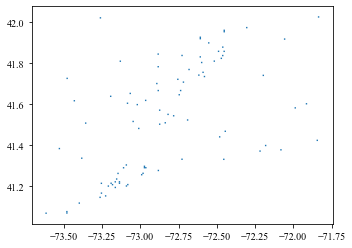

In [4]:
ct_tiles.plot()

### Read Connecticut annotated tiles' train/valid splits

In [5]:
ct_split = pd.read_csv('sample-data/tile_assignments.csv')

In [6]:
ct_split.head()

,tile_name,training_split,density_split
0,975745_sw,train,NaN
1,185895_se,train,NaN
2,205770_ne,train,NaN
3,075860_sw,train,NaN
4,015750_sw,train,NaN


### Load Connecticut town/municipality boundaries. Downloaded from [2010 U.S. Census](http://magic.lib.uconn.edu/magic_2/vector/37800/townct_37800_0000_2010_s100_census_1_t.htm)

In [7]:
ct_town_boundaries = gpd.read_file('sample-data/townct_37800_0000_2010_s100_census_1_shp/wgs84/townct_37800_0000_2010_s100_census_1_shp_wgs84.shp')

In [8]:
ct_town_boundaries.head()

,STATEFP10,COUNTYFP10,COUSUBFP10,COUSUBNS10,GEOID10,NAME10,NAMELSAD10,LSAD10,CLASSFP10,MTFCC10,...,NECTAFP10,NCTADVFP10,FUNCSTAT10,ALAND10,AWATER10,INTPTLAT10,INTPTLON10,GEOID_AFF2,GEOID_AFF1,geometry
0,09,001,00000,00000000,0900100000,County subdivisions not defined,County subdivisions not defined,00,Z9,G4040,...,None,None,F,0,302060009,+41.0779471,-073.2165184,0600000US0900100000,06000US0900100000,"POLYGON ((-73.10137 41.16388, -73.09614 41.159..."
1,09,001,04720,00213390,0900104720,Bethel,Bethel town,43,T1,G4040,...,72850,None,A,43741119,100805,+41.3697777,-073.3895032,0600000US0900104720,06000US0900104720,"POLYGON ((-73.43371 41.36737, -73.43423 41.368..."
2,09,001,08070,00213396,0900108070,Bridgeport,Bridgeport town,43,T5,G4040,...,71950,None,C,41372169,8719037,+41.1873858,-073.1957339,0600000US0900108070,06000US0900108070,"POLYGON ((-73.23338 41.14300, -73.23361 41.143..."
3,09,001,08980,00213399,0900108980,Brookfield,Brookfield town,43,T1,G4040,...,72850,None,A,51211648,1543913,+41.4698845,-073.3936666,0600000US0900108980,06000US0900108980,"POLYGON ((-73.42154 41.44794, -73.42258 41.451..."
4,09,001,18500,00213415,0900118500,Danbury,Danbury town,43,T5,G4040,...,72850,None,C,108499386,5829369,+41.4018389,-073.4722848,0600000US0900118500,06000US0900118500,"POLYGON ((-73.42378 41.45487, -73.42294 41.452..."


<AxesSubplot:>

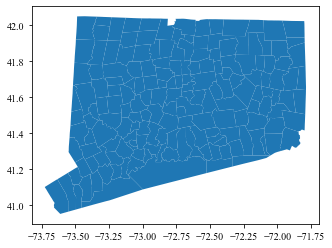

In [9]:
ct_town_boundaries.plot()

### Task: To plot sampling locations of all annotated CT tiles on CT town boundary map

#### Step 1: Get centroids of each annotated tile

In [10]:
ct_tiles_centroids = ct_tiles.centroid

<ipython-input-10-59b322ba9c75>:1: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  ct_tiles_centroids = ct_tiles.centroid


Make centroids of tiles a new GeoPandas DataFrame

In [11]:
ct_tiles_centroids = gpd.GeoDataFrame({'tile_name': ct_tiles['tile_name']}, geometry=ct_tiles.centroid)

<ipython-input-11-00cd2c42220a>:1: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  ct_tiles_centroids = gpd.GeoDataFrame({'tile_name': ct_tiles['tile_name']}, geometry=ct_tiles.centroid)


Append train/valid split information to the centroids GeoDataFrame

In [12]:
ct_split_dict = dict(zip(
    ct_split['tile_name'], ct_split['training_split']
))

ct_tiles_centroids['split'] = ct_split['tile_name'].map(ct_split_dict)

In [13]:
ct_tiles_centroids.head()

,tile_name,geometry,split
0,995820_ne,POINT (-72.75458 41.72187),train
1,990755_nw,POINT (-72.78196 41.54348),train
2,980760_sw,POINT (-72.81850 41.55032),train
3,975745_sw,POINT (-72.83671 41.50915),train
4,965765_nw,POINT (-72.87334 41.57086),train


Convert CT town boundary map from filled polygons to only outlines

In [14]:
ct_shapefile_town = ct_town_boundaries.query('NAME10 != "County subdivisions not defined"')
outer_boundary = ct_shapefile_town.geometry.unary_union

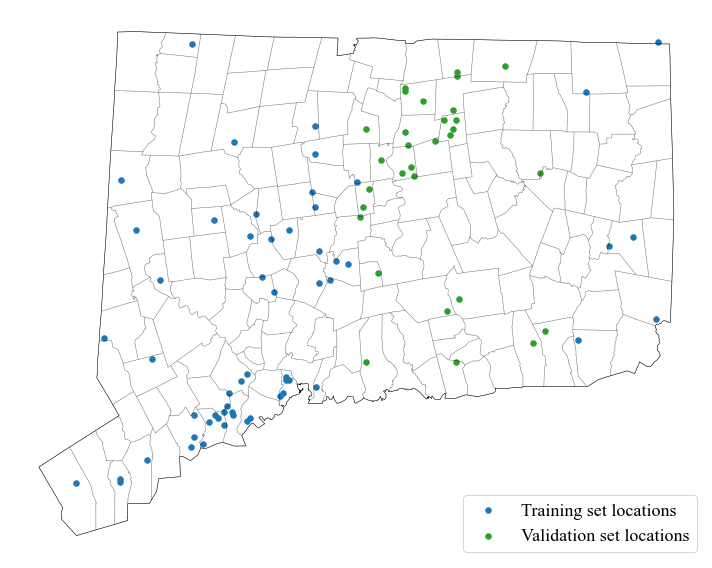

In [18]:
plt.figure(figsize=(10, 8))

# plot inner county boundaries
for i, row in ct_shapefile_town.iterrows():
    if isinstance(row.geometry, MultiPolygon):
        for pol in row.geometry.geoms:
            plt.plot(*pol.exterior.xy, c='black', linewidth=0.5, alpha=0.3)
    else:
        plt.plot(*row.geometry.exterior.xy, c='black', linewidth=0.5, alpha=0.3)

# plot outer boundary
plt.plot(*outer_boundary.geoms[0].exterior.xy, c='black', linewidth=0.5)
        
color_dict = {
    'train': 'tab:blue',
    'valid': 'tab:green'
}

full_name_dict = {
    'train': 'Training',
    'valid': 'Validation'  
}

# plot labeled ground truth points
for split in ct_tiles_centroids.split.unique():
    subset = ct_tiles_centroids.query(f'split == "{split}"')
    subset_xs = [point.x for point in subset.geometry]
    subset_ys = [point.y for point in subset.geometry]
    plt.scatter(subset_xs, subset_ys, s=30, c=color_dict[split], label=f'{full_name_dict[split]} set locations')

plt.legend(fontsize=18)
plt.axis('off')
plt.tight_layout()
plt.show()